# Code for generating sample paths of alternative models and plotting results
This notebook will first generate sample paths according to the model descriptions in Ben-Yami et al. 2023. This part does not need to be run, as there are already sample paths available to download. Runtime for 1000 sample paths for all models is about 30mins.

After generating the sample paths, the R script `AMOCestimation_altModels.Rmd` needs to be run. The files containing results of $t_c$ and the normal residuals are automatically saved in the same folder.

From these results, the histograms and QQ-plots are generated.


In [185]:
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.gofplots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcdefaults() 
#from jupyterthemes import jtplot
#jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

plt.rcParams['pgf.texsystem'] = 'pdflatex'
plt.rcParams.update({'font.family': 'serif',
                     'text.usetex': True,
                     'font.serif': ['Helvetica'],
                     'font.size': 2*8,
                     'axes.labelsize': 2*8,
                     'axes.titlesize': 2*12,
                     'figure.titlesize': 2*14})


# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = ['Arial']
# hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

### Generate sample paths of different models

In [186]:
t_start = 1870 #Time series start
t_end = 2020 #Time series end

tspan = np.linspace(t_start,t_end,(t_end-t_start)*12,endpoint=False) #Time array of samples

integration_permonth = 20 #Discretisation of integration. Same as in Ditlevsen 2023
integration_timestep = 1/(12*integration_permonth) #Corresponding time step
integration_tspan = np.linspace(t_start,t_end,(t_end-t_start)*12*integration_permonth,endpoint=False) #Time array for integration

# Values for parameters are taken from the tipping time estimation in Ditlevsen 2023
t_0 = 1924
#tau_r = 132.52
lambda_0 = -2.69
A_ = 0.87
m_ = -1.51
sigma_ = 0.3**0.5/3 #divide by 3 to avoid n-tipping

# Set tipping times/ramping lengths convenient for demonstration purposes
tau_rs = {"fnf_wn_linforc":226,
          "fnf_rn_linforc":226,
          "ou_wn_linforc":132.52,
          "ou_rn_linforc":132.52,
          "sc_wn_linforc":201,
          "fnf_wn_slowforc":150,
          "fnf_wn_accforc":106}

Model 1: Fold normal form

In [187]:

# Linear ramp of control parameter
def lambda_1a(t):
    return lambda_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_wn_linforc"])

# Fold normal form model
def f_1a(x,t):
    return -A_*(x-m_)**2-lambda_1a(t)


# Linear ramp of control parameter
def lambda_1b(t):
    return lambda_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"])

# Fold normal form model
def f_1b(x,t):
    return -A_*(x-m_)**2-lambda_1b(t)


Model 2: Ornstein-Uhlenbeck with time dependent mean

In [188]:
# Mean evolves linearly towards the value of the bifurcation point of the above fold normal form model
def mu_(t):
    return (m_+(abs(lambda_0/A_)**0.5))*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_wn_linforc"]) + m_*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_wn_linforc"]

# OU model. No tipping possible
def f_2(x,t):
    return -2*(A_*abs(lambda_0))**0.5*(x-mu_(t))


Model 3: Stommel-Cessi model

In [189]:
# Model parameters are taken from Lux et al. 2022
eta2 = 7.5
lambda_sc_0 = 0
lambda_sc_c = 2/3 + 2*eta2/27 + (1/9-1/(3*eta2))**0.5*(2*eta2/9-2/3)
vertical_scaling = (2/3 - (1/9-1/(3*eta2))**0.5)/(abs(lambda_0)/A_)**0.5 # scaling is introduced to have a similar absolute AMOC ramp to model 1

# Linear ramp of control parameter
def lambda_sc(t):
    return lambda_sc_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]) + lambda_sc_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["sc_wn_linforc"]

#Stommel-Cessi model
def f_3(x,t):
    return -(1 + eta2*((vertical_scaling*x)-1)**2)*(vertical_scaling*x)+lambda_sc(t)


Model 4: Slowing or accelerating ramps

In [190]:
# Linear ramp of control parameter, but with faster initial slope (later part is omitted)
def lambda_slow(t):
    return lambda_0*(1-np.heaviside(t-t_0,0))+np.heaviside(t-t_0,0)*lambda_0*abs(1-1.2*(t-t_0)/tau_rs["fnf_wn_slowforc"])**1

# Linear ramp of control parameter, but with slower initial slope (later part is omitted)
def lambda_acc(t):
    return lambda_0*(1-np.heaviside(t-t_0,0))+np.heaviside(t-t_0,0)*lambda_0*abs(1-0.8*(t-t_0)/tau_rs["fnf_wn_accforc"])**1

# Fold normal form models with new control parameter ramps
def f_4a(x,t):
    return -A_*(x-m_)**2-lambda_slow(t)
def f_4b(x,t):
    return -A_*(x-m_)**2-lambda_acc(t)


Integrate each of the models using the Euler(-Maruyama) method and save the paths to txt files
### Do not run unless you would like to make changes to the models. Data is available. Activate the models through the respective if clause

In [191]:


samplesize = 1000
sampless = []

os.makedirs("SamplePathData/",exist_ok=True)
os.makedirs("SamplePathData/fnf_wn_linforc/",exist_ok=True)
os.makedirs("SamplePathData/fnf_rn_linforc/",exist_ok=True)
os.makedirs("SamplePathData/ou_wn_linforc/",exist_ok=True)
os.makedirs("SamplePathData/ou_rn_linforc/",exist_ok=True)
os.makedirs("SamplePathData/sc_wn_linforc/",exist_ok=True)
os.makedirs("SamplePathData/fnf_wn_slowforc/",exist_ok=True)
os.makedirs("SamplePathData/fnf_wn_accforc/",exist_ok=True)

for k in range(samplesize):
    if 0:
        white_noise_instance = np.random.normal(0,sigma_,(t_end-t_start)*12*integration_permonth)
        sample_1a = [m_+(abs(lambda_0)/A_)**0.5]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_1a.append(sample_1a[-1] + (f_1a(sample_1a[-1],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5)
            if sample_1a[-1]<-2:
                sample_1a[-1] = -2
                print("tip1a")
        sample_1a = np.array(sample_1a[::integration_permonth])
        np.savetxt("SamplePathData/fnf_wn_linforc/"+str(k+1)+".txt",sample_1a)

    if 0:
        theta_0 = 20
        theta_c = 17
        thetas = np.array([theta_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"]) + theta_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["fnf_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*18
        red_noise_instance = [np.random.normal(0,kappa/(2*theta_0)**0.5)]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        sample_1b = [m_+(abs(lambda_0)/A_)**0.5]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_1b.append(sample_1b[-1] + (f_1b(sample_1b[-1],integration_tspan[i]))*integration_timestep + red_noise_instance[i]*integration_timestep)
            if sample_1b[-1]<-2:
                sample_1b[-1] = -2
                print("tip1b")
        sample_1b = np.array(sample_1b[::integration_permonth])
        np.savetxt("SamplePathData/fnf_rn_linforc/"+str(k+1)+".txt",sample_1b)

    if 0:
        white_noise_instance = np.random.normal(0,sigma_,(t_end-t_start)*12*integration_permonth)
        sample_2a = [mu_(t_start)]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_2a.append(sample_2a[-1] + f_2(sample_2a[-1],integration_tspan[i])*integration_timestep + white_noise_instance[i]*integration_timestep**0.5)
        sample_2a = np.array(sample_2a[::integration_permonth])
        np.savetxt("SamplePathData/ou_wn_linforc/"+str(k+1)+".txt",sample_2a)

    if 0:
        theta_0 = 20
        theta_c = 5
        thetas = np.array([theta_0*(1-np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"]) + theta_c*np.heaviside(t-t_0,0)*(t-t_0)/tau_rs["ou_rn_linforc"] for t in integration_tspan])
        ar1_coeffs = np.exp(-thetas*integration_timestep)
        kappa = sigma_*(2*thetas[0])**0.5*18
        red_noise_instance = [np.random.normal(0,kappa/(2*theta_0)**0.5)]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            red_noise_instance.append(ar1_coeffs[i]*red_noise_instance[-1] + np.sqrt(kappa / (2 * thetas[i]) * (1 - np.exp(-2 * thetas[i] * integration_timestep))) * np.random.normal(0, 1))
        red_noise_instance = np.array(red_noise_instance)

        sample_2b = [mu_(t_start)]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_2b.append(sample_2b[-1] + f_2(sample_2b[-1],integration_tspan[i])*integration_timestep + red_noise_instance[i]*integration_timestep)
        sample_2b = np.array(sample_2b[::integration_permonth])
        np.savetxt("SamplePathData/ou_rn_linforc/"+str(k+1)+".txt",sample_2b)

    if 0:
        white_noise_instance = np.random.normal(0,sigma_,(t_end-t_start)*12*integration_permonth)
        sc_noise_scaling = 0.8
        sample_3 = [m_+(abs(lambda_0)/A_)**0.5]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_3.append(sample_3[-1] + f_3(sample_3[-1],integration_tspan[i])*integration_timestep + sc_noise_scaling*white_noise_instance[i]*integration_timestep**0.5)
        sample_3 = np.array(sample_3[::integration_permonth])
        sample_3 = -1*(sample_3 - (m_+(abs(lambda_0)/A_)**0.5))
        np.savetxt("SamplePathData/sc_wn_linforc/"+str(k+1)+".txt",sample_3)

    if 0:  
        white_noise_instance = np.random.normal(0,sigma_,(t_end-t_start)*12*integration_permonth)
        sample_4a = [m_+(abs(lambda_0)/A_)**0.5]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_4a.append(sample_4a[-1] + (f_4a(sample_4a[-1],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5)
            if sample_4a[-1]<-2:
                sample_4a[-1] = -2
                print("tip4a")
        sample_4a = np.array(sample_4a[::integration_permonth])
        np.savetxt("SamplePathData/fnf_wn_slowforc/"+str(k+1)+".txt",sample_4a)

    if 0:
        white_noise_instance = np.random.normal(0,sigma_,(t_end-t_start)*12*integration_permonth)
        sample_4b = [m_+(abs(lambda_0)/A_)**0.5]
        for i in range((t_end-t_start)*12*integration_permonth-1):
            sample_4b.append(sample_4b[-1] + (f_4b(sample_4b[-1],integration_tspan[i]))*integration_timestep + white_noise_instance[i]*integration_timestep**0.5)
            if sample_4b[-1]<-2:
                sample_4b[-1] = -2
                print("tip4b")
        sample_4b = np.array(sample_4b[::integration_permonth])
        np.savetxt("SamplePathData/fnf_wn_accforc/"+str(k+1)+".txt",sample_4b)

### Plot results obtained from the R script

In [195]:
modelnames= ["fnf_wn_linforc","fnf_rn_linforc","sc_wn_linforc","ou_wn_linforc","ou_rn_linforc","fnf_wn_slowforc","fnf_wn_accforc"]
t_left = 2020
t_right = 2200
t_step = 5


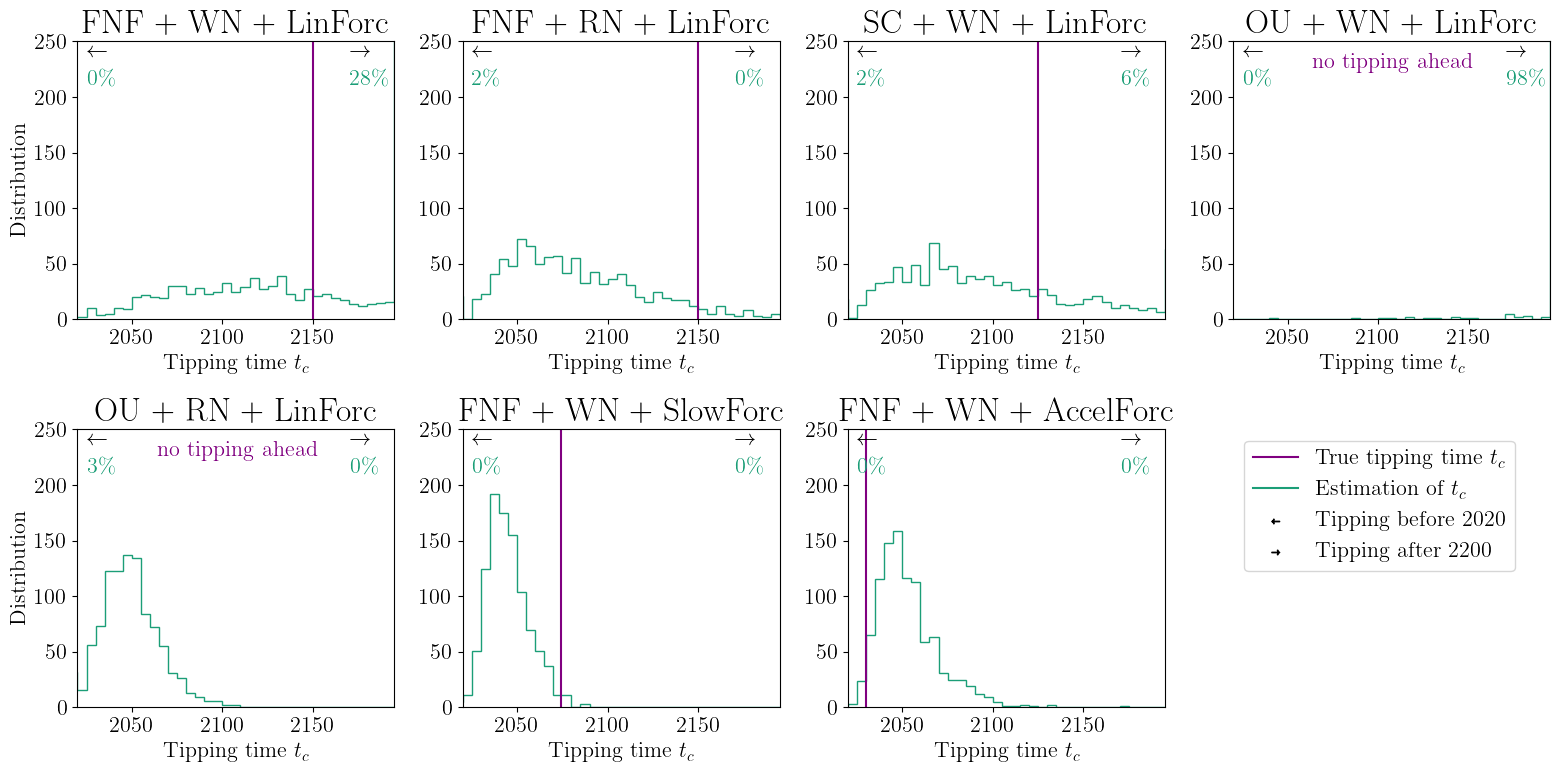

In [198]:
modeldescrips = ["FNF + WN + LinForc","FNF + RN + LinForc","SC + WN + LinForc","OU + WN + LinForc","OU + RN + LinForc","FNF + WN + SlowForc","FNF + WN + AccelForc"]
fig, axs = plt.subplots(nrows=2,ncols=4,figsize=(16,8),tight_layout=True)
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
for i in range(len(modelnames)):
    t_c_values_2 = np.array(pd.read_excel("EstimMatrix_"+modelnames[i]+".xlsx").loc[:,"tc"])
    samplesize_2 = len(t_c_values_2)
    hist_2 = axs[i].hist(t_c_values_2,bins=bins,histtype="step",density=False)[0]
    axs[i].set_xlabel("Tipping time $t_c$")
    axs[i].text(0.03,0.93,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.03,0.84,str(round(hist_2[0]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].text(0.86,0.93,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.86,0.84,str(round(hist_2[-1]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].set_xlim(t_left,t_right-t_step)
    axs[i].set_ylim(0,250)
    #axs[i].ticklabel_format(axis='y', style='sci',scilimits=(0,0))
    axs[i].set_title(modeldescrips[i])
    if i in [0,1,2,5,6]:
        axs[i].axvline(t_0+tau_rs[modelnames[i]],c="purple")
    else:
        axs[i].text(0.25,0.9,"no tipping ahead",c="purple", transform=axs[i].transAxes)
axs[0].set_ylabel("Distribution")
axs[4].set_ylabel("Distribution")
axs[len(modelnames)].plot([0,1],[0,1],c="purple")
axs[len(modelnames)].plot([0,1],[0,1])
axs[len(modelnames)].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[len(modelnames)].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[len(modelnames)].set_ylim(-1,-0.5)
axs[len(modelnames)].legend(["True tipping time $t_c$","Estimation of $t_c$","Tipping before "+str(t_left), "Tipping after "+str(t_right)],loc="upper left")
axs[len(modelnames)].axis("off")

#plt.savefig("Plots/method2_tcdists_" + time.strftime("%Y%m%d-%H%M%S"),dpi=300,bbox_inches="tight")
plt.show()

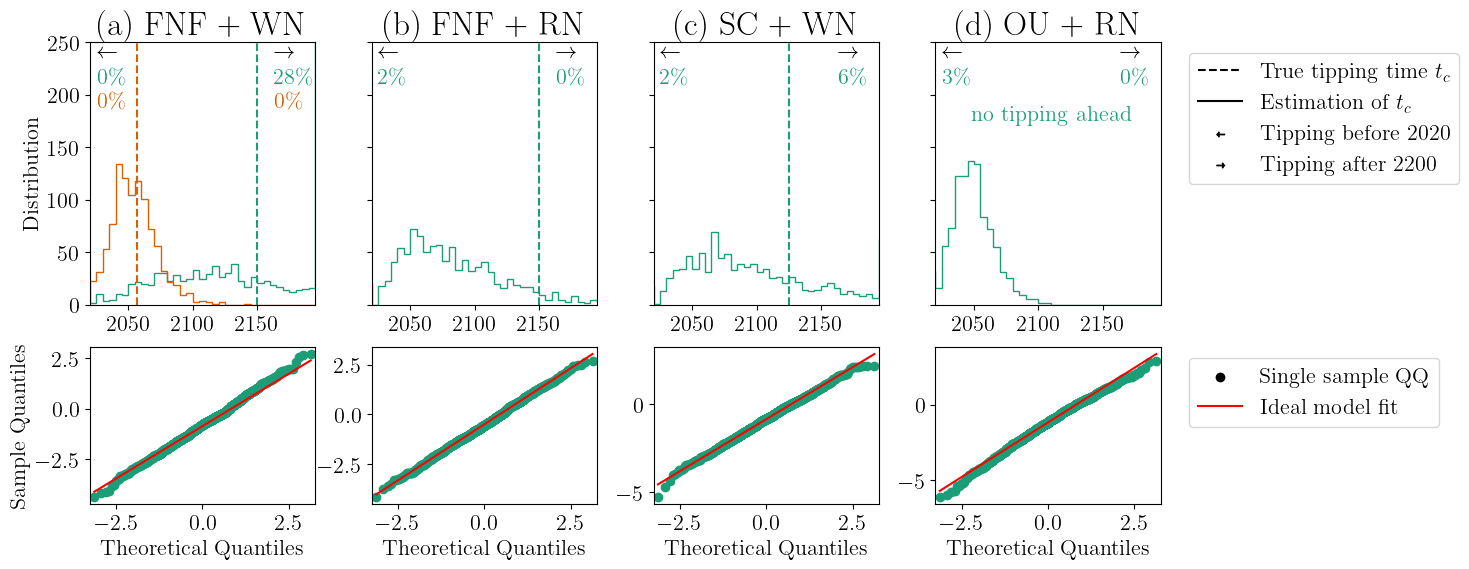

In [200]:
model_subselection = [0,1,2,4]
modeldescrips = ["(a) FNF + WN","(b) FNF + RN","(c) SC + WN","(d) OU + RN"]
ncols = 5
fig, axs = plt.subplots(nrows=2,ncols=ncols,figsize=(16,6),gridspec_kw={'height_ratios': [1, 0.6], 'width_ratios': [1,1,1,1, 0.5]})
axs=axs.flatten()
bins = np.concatenate((np.array([0]),np.arange(t_left,t_right,t_step),np.array([1e20])))
for i in range(len(model_subselection)):
    t_c_values_2 = np.array(pd.read_excel("EstimMatrix_"+modelnames[model_subselection[i]]+".xlsx").loc[:,"tc"])
    samplesize_2 = len(t_c_values_2)
    hist_2 = axs[i].hist(t_c_values_2,bins=bins,histtype="step",density=False)[0]
    #axs[i].set_xlabel("Tipping time $t_c$")
    axs[i].text(0.03,0.93,r"$\leftarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.03,0.84,str(round(hist_2[0]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].text(0.82,0.93,r"$\rightarrow$",color="black", transform=axs[i].transAxes)
    axs[i].text(0.82,0.84,str(round(hist_2[-1]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    axs[i].set_xlim(t_left,t_right-t_step)
    axs[i].set_ylim(0,250)
    axs[i].set_title(modeldescrips[i])
    if i == 0:
        t_c_values_2 = np.array(pd.read_excel("EstimMatrix_1000repetitions.xlsx").loc[:,"tc"])
        samplesize_2 = len(t_c_values_2)
        hist_2 = axs[i].hist(t_c_values_2,bins=bins,histtype="step",density=False)[0]
        axs[i].axvline(2057,color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1],linestyle="dashed")
        axs[i].text(0.03,0.75,str(round(hist_2[0]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
        axs[i].text(0.82,0.75,str(round(hist_2[-1]*100/samplesize_2))+"$\%$",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1], transform=axs[i].transAxes)
    if model_subselection[i] in [0,1,2,5,6]:
        axs[i].axvline(t_0+tau_rs[modelnames[model_subselection[i]]],color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0],linestyle="dashed")
    else:
        axs[i].text(0.16,0.7,"no tipping ahead",color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0], transform=axs[i].transAxes)
    QQData = pd.read_csv("QQData_"+modelnames[model_subselection[i]]+".csv",index_col=0).values[:,0]
    statsmodels.graphics.gofplots.qqplot(QQData,ax=axs[i+ncols],line="q")
    if not i == 0:
        axs[i+ncols].set_ylabel("")
        axs[i].set_yticklabels([])
axs[0].set_ylabel("Distribution")
axs[len(model_subselection)].plot([0,1],[0,1],color="black",linestyle="dashed")
axs[len(model_subselection)].plot([0,1],[0,1],color="black")
axs[len(model_subselection)].scatter([0],[0],marker=r"$\leftarrow$",c="black")
axs[len(model_subselection)].scatter([0],[0],marker=r"$\rightarrow$",c="black")
axs[len(model_subselection)].set_ylim(-1,-0.5)
axs[len(model_subselection)].legend(["True tipping time $t_c$","Estimation of $t_c$","Tipping before "+str(t_left), "Tipping after "+str(t_right)],loc="upper left", bbox_to_anchor=(-0.35,1))
axs[len(model_subselection)].axis("off")
axs[len(model_subselection)+ncols].scatter([0],[0],color="black")
axs[len(model_subselection)+ncols].plot([0,1],[0,1],c="red")
axs[len(model_subselection)+ncols].set_ylim(-1,-0.5)
axs[len(model_subselection)+ncols].legend(["Single sample QQ","Ideal model fit"],loc="upper left", bbox_to_anchor=(-0.35,1))
axs[len(model_subselection)+ncols].axis("off")

fig.subplots_adjust(hspace=0.2,wspace=0.28)
plt.savefig("Plots/modelsubselection_QQ" + time.strftime("%Y%m%d-%H%M%S") + ".pdf",dpi=300,bbox_inches="tight")
plt.show()